In [1]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
from PIL import Image
import matplotlib.pyplot as plt
from src.DataGenerator import AudioDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , Flatten, Reshape, Conv2DTranspose, BatchNormalization, Conv1D, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from src.helper_functions import plot_reconstruction
import seaborn as sns


In [2]:
data_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512), 
    color_mode='rgb',
    batch_size=32,
    sample_size=128000,
    shuffle=True,
    train_test_split=True, 
    test_size=0.02,
    output_channel_index=0,
    output_size=(128,128))


Found 125440 files for Training set
Found 2560 files for Test set


In [3]:
img_width = 128
img_height = 128
kernel_size = 5
strides = 2

In [4]:
class Time_Freq_Autoencoder_Builder:
    
    def build(width, height, depth, filters=(32,64,128,256), latent_dim=256, kernel_size=5):
        
        strides = 2
        
        input_shape = (height, width, depth)
        inputs = Input(shape = input_shape)
        
        chan_dim = -1
        
        x_time = Reshape(target_shape=(height,width))(inputs)
        x_freq = Reshape(target_shape=(height,width))(tf.transpose(inputs, perm=[0,2,1,3]))
        
        for f in filters:
            
            x_time = Conv1D(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x_time)
            x_time = BatchNormalization(axis=chan_dim)(x_time)
            
        x_time = Flatten()(x_time)
        latent_time = Dense(latent_dim//2)(x_time)
        
        for f in filters:
            
            x_freq = Conv1D(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x_freq)
            x_freq = BatchNormalization(axis=chan_dim)(x_freq)
            
        x_freq = Flatten()(x_freq)
        latent_freq = Dense(latent_dim//2)(x_freq)
        
        
        latent_concat = tf.keras.layers.Concatenate(axis=1)([latent_time, latent_freq])
        
        encoder = Model(inputs, latent_concat, name='encoder')
        
        latent_inputs = Input(shape=((latent_dim//2)*2))
        
        x = Dense(16384, activation='relu')(latent_inputs)
        x = Reshape(target_shape=(8,8,256))(x)
        
        for f in filters[::-1]:
            
            x = Conv2DTranspose(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x)
            x = BatchNormalization(axis=chan_dim)(x)
            
        x = Conv2DTranspose(depth, kernel_size=kernel_size, padding='same', activation='sigmoid')(x)
        
        outputs = x
        
        decoder = Model(latent_inputs, outputs, name='decoder')
        
        autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
        
        return (encoder, decoder, autoencoder)
    

class Time_Freq_Autoencoder(tf.keras.Model):
    
    def __init__(self, image_width, image_height, image_depth=1, latent_dim=256, kernel_size=5):
        super().__init__()
        
        self.encoder, self.decoder, self.autoencoder = Time_Freq_Autoencoder_Builder.build(width=image_width, height=image_height, depth=image_depth, latent_dim=256, kernel_size=kernel_size)
        
    def call(self, x):
        autoencoded = self.autoencoder(x)
        return autoencoded
    
autoencoder = Time_Freq_Autoencoder(image_width=img_width, image_height=img_height, latent_dim=256, kernel_size=5)

In [5]:
opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [6]:
autoencoder.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.compat.v1.transpose (TFOpLa  (None, 128, 128, 1)  0          ['input_1[0][0]']                
 mbda)                                                                                            
                                                                                                  
 reshape (Reshape)              (None, 128, 128)     0           ['input_1[0][0]']                
                                                                                            

In [7]:
autoencoder_path = 'data/autoencoder_256dim_time_freq_128k_20epochs'

autoencoder = tf.keras.models.load_model(autoencoder_path)

In [8]:
hist = autoencoder.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=10,
                       validation_data=data_gen.test)

Epoch 1/10


2022-08-21 23:13:37.982159: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3920/3920 [==============================] - 2361s 602ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 2/10
3920/3920 [==============================] - 2350s 600ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 3/10
3920/3920 [==============================] - 2353s 600ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/10
3920/3920 [==============================] - 2353s 600ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 5/10
3920/3920 [==============================] - 2351s 600ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/10
3920/3920 [==============================] - 2348s 599ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 7/10
3920/3920 [==============================] - 2346s 598ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/10
3920/3920 [==============================] - 2351s 600ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/10
3920/3920 [==============================] - 2348s 599ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 10/10
3920/3920 [=========================

In [9]:
autoencoder_path = 'data/autoencoder_256dim_time_freq_128k_20epochs'

In [10]:
autoencoder.save(autoencoder_path)

INFO:tensorflow:Assets written to: data/autoencoder_256dim_time_freq_128k_20epochs/assets


INFO:tensorflow:Assets written to: data/autoencoder_256dim_time_freq_128k_20epochs/assets


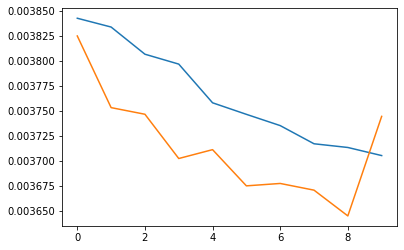

In [11]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(range(len(loss)), loss)
plt.plot(range(len(val_loss)), val_loss)

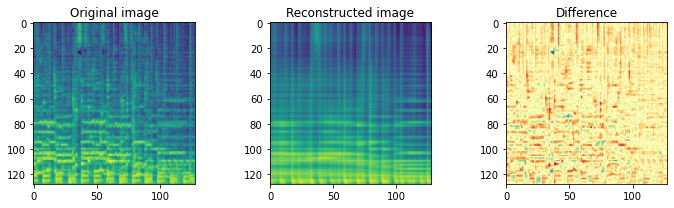

In [12]:
test_img = data_gen.take(1)[0]
prediction = autoencoder(test_img)

plot_reconstruction(test_img, prediction, 1)

In [22]:
from src.LatentSpace import LatentSpace

latent_space = LatentSpace(autoencoder_path=autoencoder_path,
                        image_dir='data/Spotify/comp_pngs/',
                        tracks_feather_path='data/all_tracks.feather',
                       latent_dims=256,
                       output_size=(128, 128),
                       num_tiles=32
                        )

Found 278581 files for Generator set


In [ ]:
latent_space.build()
latent_space.save(autoencoder_path)